In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
df_abs = pd.read_csv('cause_of_deaths.csv')
cols = df_abs.columns

df_abs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6120 entries, 0 to 6119
Data columns (total 34 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   Country/Territory                           6120 non-null   object
 1   Code                                        6120 non-null   object
 2   Year                                        6120 non-null   int64 
 3   Meningitis                                  6120 non-null   int64 
 4   Alzheimer's Disease and Other Dementias     6120 non-null   int64 
 5   Parkinson's Disease                         6120 non-null   int64 
 6   Nutritional Deficiencies                    6120 non-null   int64 
 7   Malaria                                     6120 non-null   int64 
 8   Drowning                                    6120 non-null   int64 
 9   Interpersonal Violence                      6120 non-null   int64 
 10  Maternal Disorders      

In [3]:
stat_cols = ["Meningitis",
       "Alzheimer's Disease and Other Dementias", "Parkinson's Disease",
       "Nutritional Deficiencies", "Malaria", "Drowning",
       "Interpersonal Violence", "Maternal Disorders", "HIV/AIDS",
       "Drug Use Disorders", "Tuberculosis", "Cardiovascular Diseases",
       "Lower Respiratory Infections", "Neonatal Disorders",
       "Alcohol Use Disorders", "Self-harm", "Exposure to Forces of Nature",
       "Diarrheal Diseases", "Environmental Heat and Cold Exposure",
       "Neoplasms", "Conflict and Terrorism", "Diabetes Mellitus",
       "Chronic Kidney Disease", "Poisonings", "Protein-Energy Malnutrition",
       "Road Injuries", "Chronic Respiratory Diseases",
       "Cirrhosis and Other Chronic Liver Diseases", "Digestive Diseases",
       "Fire, Heat, and Hot Substances", "Acute Hepatitis"]

df = df_abs.drop(columns=['Country/Territory', 'Code', 'Year'])
df['row_sum'] = df.sum(axis=1)
df = df.div(df['row_sum'], axis=0).drop(columns=['row_sum'])

df = pd.concat([df_abs[['Country/Territory', 'Code', 'Year']], df], axis=1)
# df.to_csv('cause_of_death_norm.csv', index=False)

In [4]:
from sklearn.cluster import KMeans

# Filter the 2019 data
df_2019 = df[df['Year'] == 2019].copy()

# Drop non-numeric columns for clustering
df_2019_numeric = df_2019.drop(columns=['Country/Territory', 'Code', 'Year'])

# Run k-means clustering
kmeans = KMeans(n_clusters=5, random_state=0).fit(df_2019_numeric)

# Add the cluster labels to the dataframe
df_2019['Cluster'] = kmeans.labels_
df_2019['Cluster'] = df_2019['Cluster'] + 1
df_2019['Cluster'] = df_2019['Cluster'].astype(int).astype(str)

print(df_2019[['Country/Territory', 'Cluster']])

         Country/Territory Cluster
29             Afghanistan       5
59                  Angola       3
89                 Albania       4
119                Andorra       1
149   United Arab Emirates       2
...                    ...     ...
5999                 Samoa       5
6029                 Yemen       5
6059          South Africa       3
6089                Zambia       3
6119              Zimbabwe       3

[204 rows x 2 columns]


c:\Users\stple\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


C:\Users\stple\AppData\Local\Temp\ipykernel_58564\2814169860.py:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


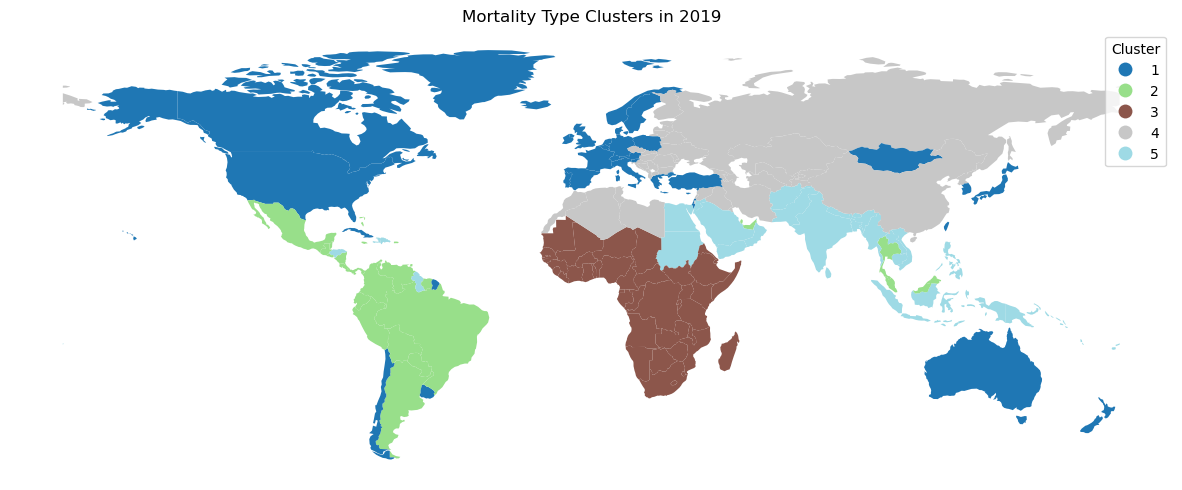

In [5]:
import geopandas as gpd

# Load a world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge the world map with the 2019 data
world_base = world.merge(df_2019, how="left", left_on="iso_a3", right_on="Code")

# Plot the map with clusters
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world_base.plot(column='Cluster', ax=ax, legend=True, categorical=True, cmap='tab20', legend_kwds={'title': 'Cluster'})
ax.axis('off')
plt.title('Mortality Type Clusters in 2019')
plt.show()

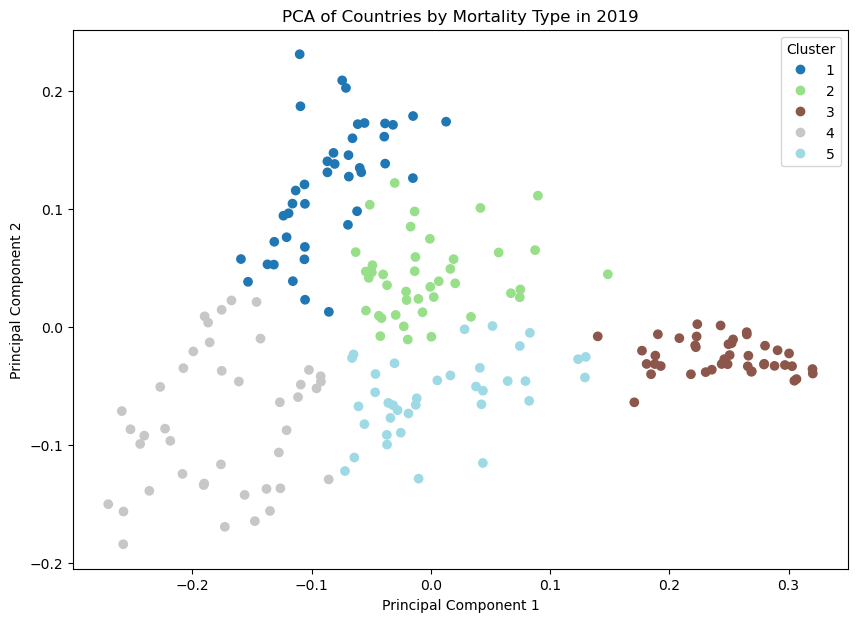

In [6]:
from sklearn.decomposition import PCA

# Drop non-numeric columns for PCA
df_2019_numeric = df_2019.drop(columns=['Country/Territory', 'Code', 'Year', 'Cluster'])

# Run PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_2019_numeric)

# Create a df with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])

# Add the cluster labels to the PCA df
pca_df['Cluster'] = df_2019['Cluster'].values
pca_df['Cluster'] = pca_df['Cluster'].astype(int)

# Plot the top 2 principal components
plt.figure(figsize=(10, 7))
scatter = plt.scatter(pca_df['Principal Component 1'], pca_df['Principal Component 2'], c=pca_df['Cluster'], cmap='tab20')
plt.title('PCA of Countries by Mortality Type in 2019')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()

In [7]:
categories = pd.read_excel('categories.xlsx')
categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Mortality Type      31 non-null     object
 1   Mortality Category  31 non-null     object
dtypes: object(2)
memory usage: 628.0+ bytes


In [8]:
# Map mortality types to categories
category_map = categories.set_index('Mortality Type')['Mortality Category'].to_dict()

# Sum the values over each mortality type in the category
df_2019_categories = pd.DataFrame()
for category in categories['Mortality Category'].unique():
    mortality_types = categories[categories['Mortality Category'] == category]['Mortality Type']
    df_2019_categories[category] = df_2019[mortality_types].sum(axis=1)

# Add the non-numeric columns back to the dataframe
df_2019_categories = pd.concat([df_2019[['Country/Territory', 'Code', 'Year', 'Cluster']], df_2019_categories], axis=1)

df_2019_categories.head()

,Country/Territory,Code,Year,Cluster,Infectious Diseases,Chronic Diseases,Nutritional and Neonatal Disorders,Substance Use and Mental Health Disorders,Environmental and External Causes,Digestive Diseases
29,Afghanistan,AFG,2019,5,0.142413,0.491222,0.138728,0.009952,0.185847,0.031837
59,Angola,AGO,2019,3,0.391271,0.323191,0.151027,0.012801,0.069955,0.051754
89,Albania,ALB,2019,4,0.022082,0.918642,0.007736,0.008950,0.018889,0.023701
119,Andorra,AND,2019,1,0.042589,0.882453,0.000000,0.015332,0.013629,0.045997
149,United Arab Emirates,ARE,2019,2,0.039084,0.713302,0.003868,0.056912,0.159797,0.027038


c:\Users\stple\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


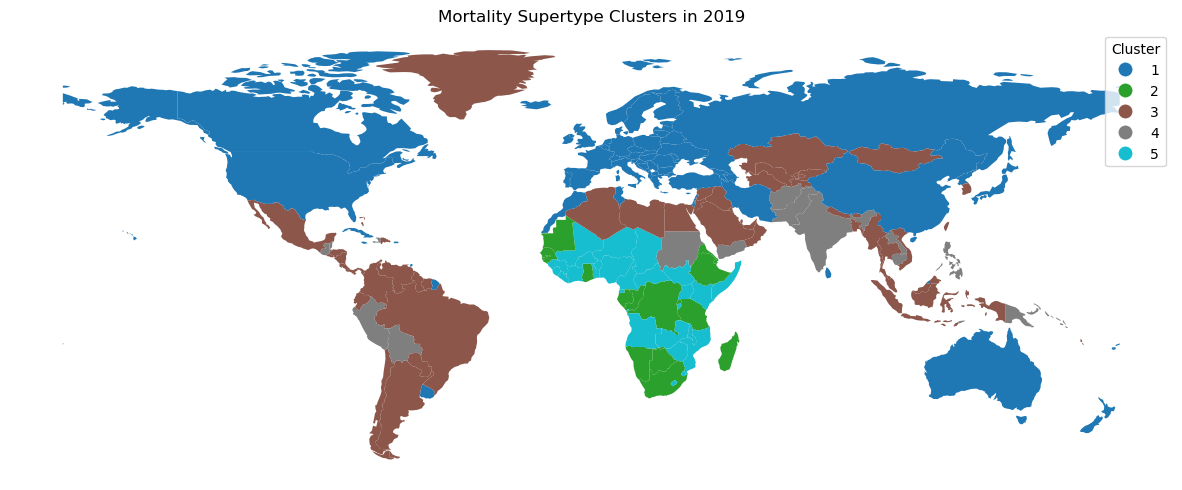

In [9]:
from sklearn.cluster import KMeans

# Drop non-numeric columns for clustering
df_2019_categories_numeric = df_2019_categories.drop(columns=['Country/Territory', 'Code', 'Year', 'Cluster'])

# Run k-means clustering
kmeans_categories = KMeans(n_clusters=5, random_state=0).fit(df_2019_categories_numeric)

# Add the cluster labels to the dataframe
df_2019_categories['Cluster'] = kmeans_categories.labels_ + 1
df_2019_categories['Cluster'] = df_2019_categories['Cluster'].astype(int).astype(str)

# Merge the world map with the 2019 categories data
world_categories = world.merge(df_2019_categories, how="left", left_on="iso_a3", right_on="Code")

# Plot the map with clusters
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world_categories.plot(column='Cluster', ax=ax, legend=True, categorical=True, cmap='tab10', legend_kwds={'title': 'Cluster'}, linewidth=0.8)
ax.axis('off')
plt.title('Mortality Supertype Clusters in 2019')
plt.show()

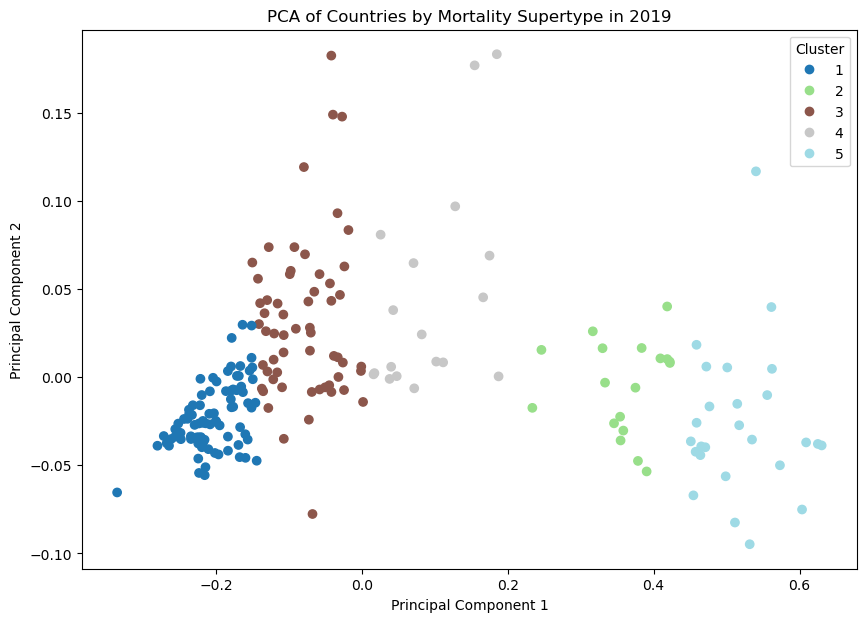

In [10]:
# Drop non-numeric columns for PCA
df_2019_categories_numeric = df_2019_categories.drop(columns=['Country/Territory', 'Code', 'Year', 'Cluster'])

# Run PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_2019_categories_numeric)

# Create a df with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])

# Add the cluster labels to the PCA df
pca_df['Cluster'] = df_2019_categories['Cluster'].values
pca_df['Cluster'] = pca_df['Cluster'].astype(int)

# Plot the top 2 principal components
plt.figure(figsize=(10, 7))
scatter = plt.scatter(pca_df['Principal Component 1'], pca_df['Principal Component 2'], c=pca_df['Cluster'], cmap='tab20')
plt.title('PCA of Countries by Mortality Supertype in 2019')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()

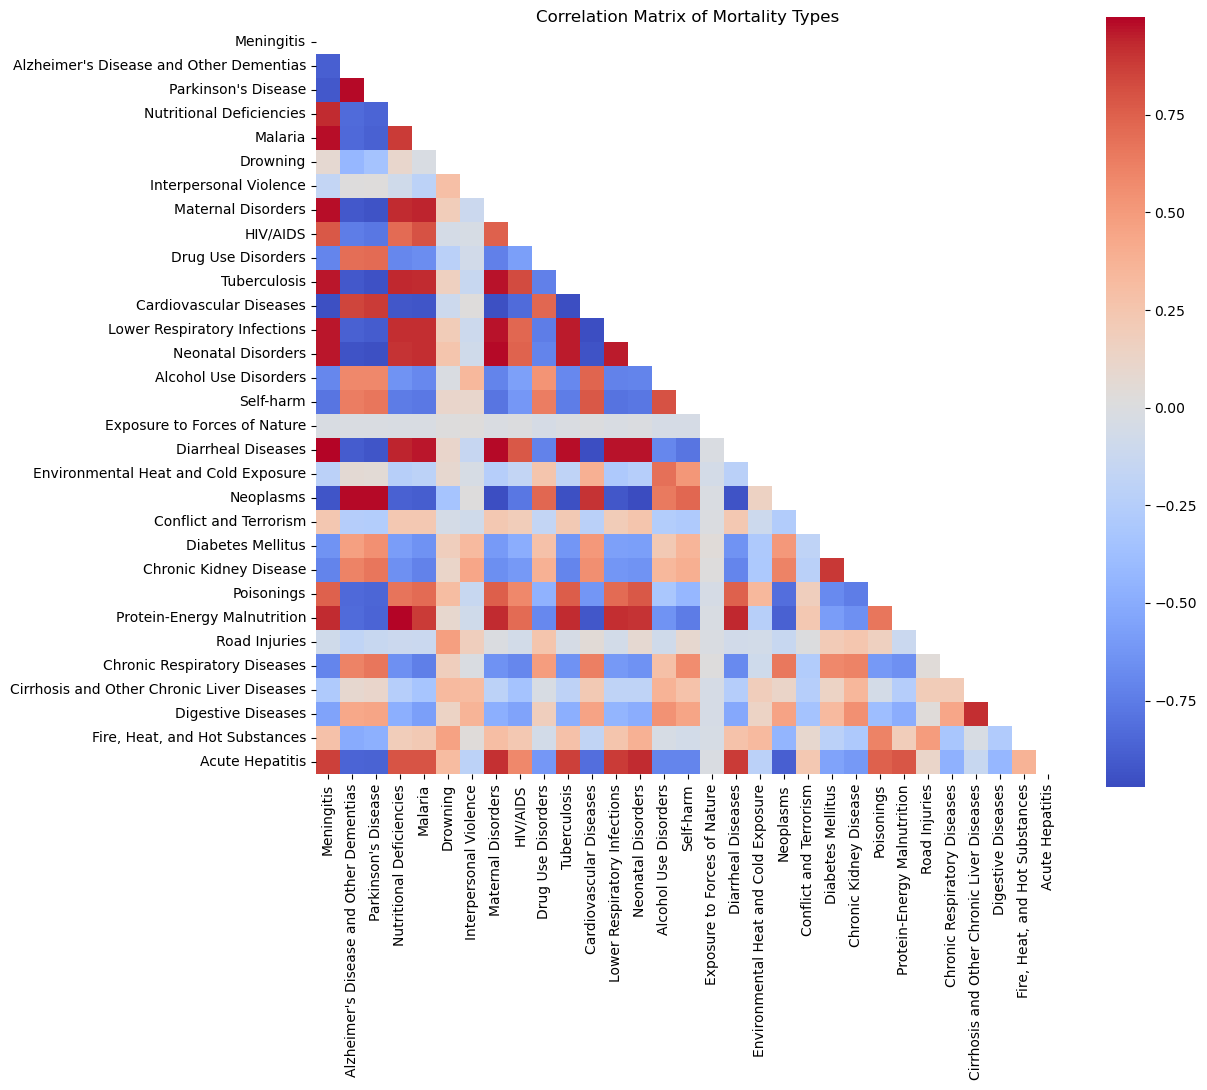

In [11]:
import seaborn as sns

# Remove qualitative columns
df_numeric = df.drop(columns=['Country/Territory', 'Code', 'Year']).corr()

# Correlation matrix of mortality proportions
data_matrix = df_numeric.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(data_matrix, dtype=bool))

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(data_matrix, mask=mask, cmap='coolwarm', annot=False, fmt=".2f", square=True)

plt.title('Correlation Matrix of Mortality Types')
plt.show()

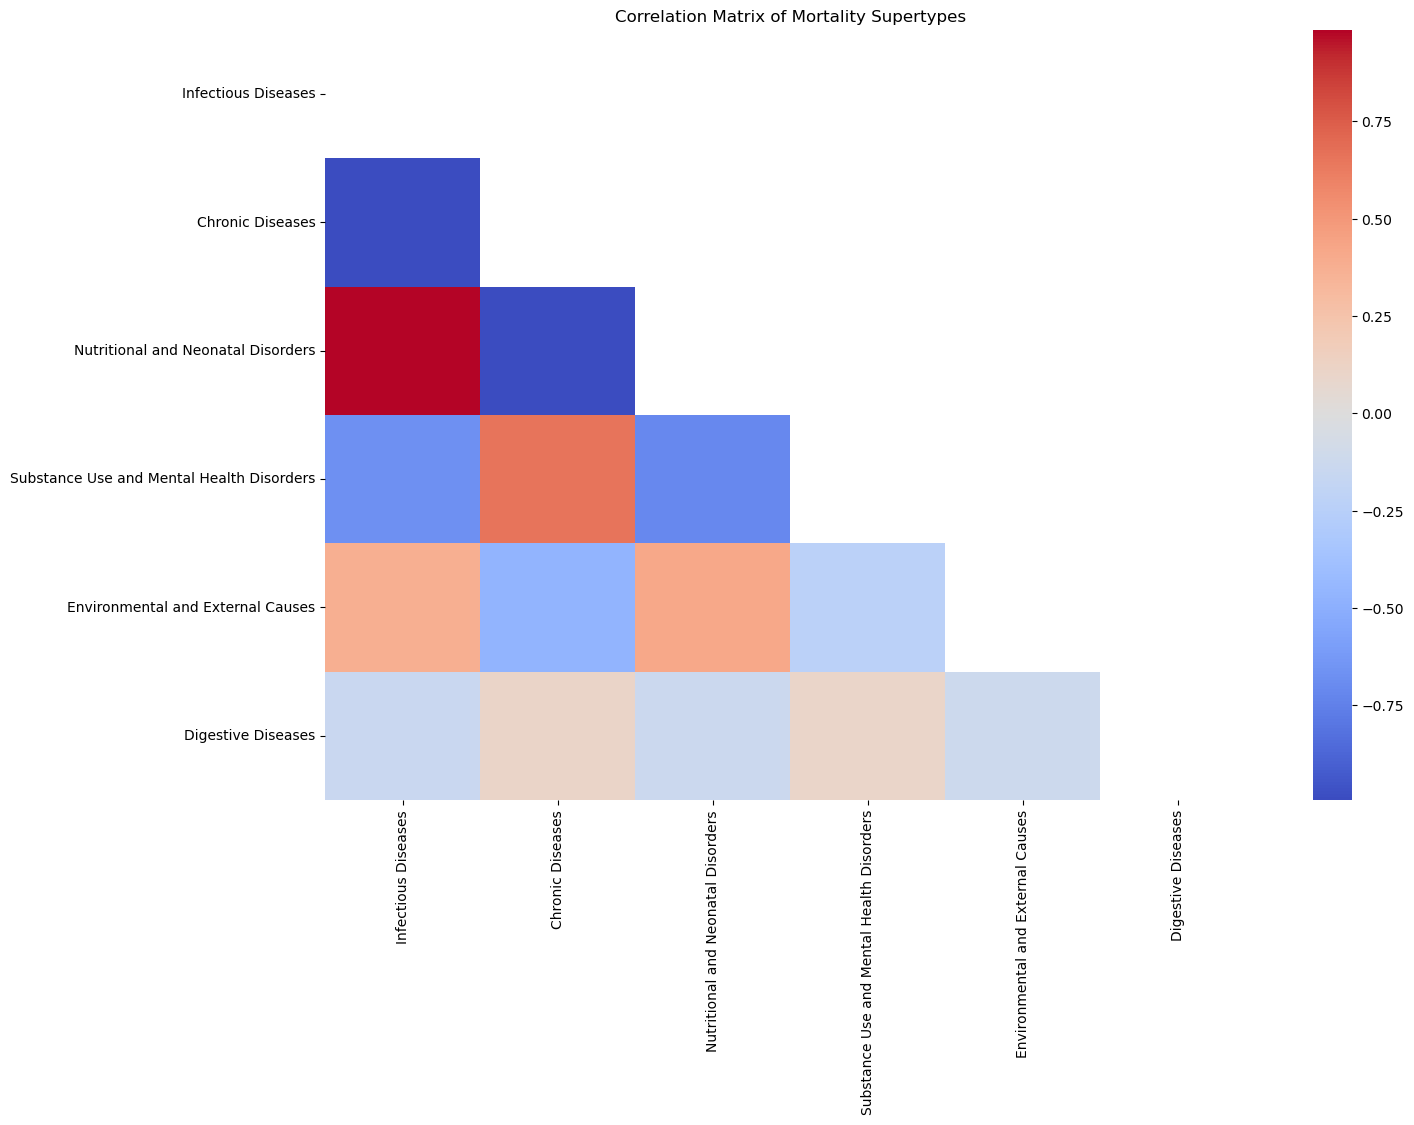

In [12]:
# Remove qualitative columns
df_2019_categories_numeric = df_2019_categories.drop(columns=['Country/Territory', 'Code', 'Year', 'Cluster']).corr()

# Calculate the correlation matrix
correlation_matrix = df_2019_categories_numeric.corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Mortality Supertypes')
plt.show()

In [13]:
# Group by year and sum the values for each cause of death
global_mortality_by_year = df_abs.groupby('Year').sum()

global_mortality_by_year.drop(columns=['Country/Territory','Code'], inplace=True)

# Calculate the proportion of each cause of death relative to the total deaths for that year
global_mortality_proportion_by_year = global_mortality_by_year.div(global_mortality_by_year.sum(axis=1), axis=0)

global_mortality_proportion_by_year.head()
# global_mortality_proportion_by_year.to_excel('global_mortality_proportion_by_year.xlsx')

,Meningitis,Alzheimer's Disease and Other Dementias,Parkinson's Disease,Nutritional Deficiencies,Malaria,Drowning,Interpersonal Violence,Maternal Disorders,HIV/AIDS,Drug Use Disorders,...,Diabetes Mellitus,Chronic Kidney Disease,Poisonings,Protein-Energy Malnutrition,Road Injuries,Chronic Respiratory Diseases,Cirrhosis and Other Chronic Liver Diseases,Digestive Diseases,"Fire, Heat, and Hot Substances",Acute Hepatitis
Year,,,,,,,,,,,,,,,,,,,,,
1990,0.009933,0.012882,0.003381,0.017390,0.019309,0.010581,0.008560,0.006949,0.007722,0.001290,...,0.015191,0.013808,0.002021,0.015073,0.025570,0.071068,0.023264,0.042612,0.002829,0.003822
1991,0.009728,0.013236,0.003424,0.016549,0.019496,0.010313,0.008708,0.006770,0.009776,0.001405,...,0.015425,0.013926,0.001993,0.014322,0.025352,0.071455,0.023306,0.042613,0.002813,0.003751
1992,0.009592,0.013628,0.003484,0.015760,0.019263,0.010055,0.009158,0.006732,0.012148,0.001503,...,0.015795,0.014174,0.001989,0.013631,0.025317,0.072152,0.023459,0.042820,0.002811,0.003682
1993,0.009313,0.013933,0.003546,0.014921,0.019082,0.009858,0.009580,0.006497,0.014705,0.001585,...,0.016113,0.014324,0.001993,0.012923,0.025173,0.072293,0.023630,0.042924,0.002822,0.003583
1994,0.008960,0.014122,0.003559,0.014070,0.018528,0.009600,0.009570,0.006348,0.017326,0.001661,...,0.016267,0.014407,0.001968,0.012213,0.024980,0.071397,0.023587,0.042606,0.002806,0.003452


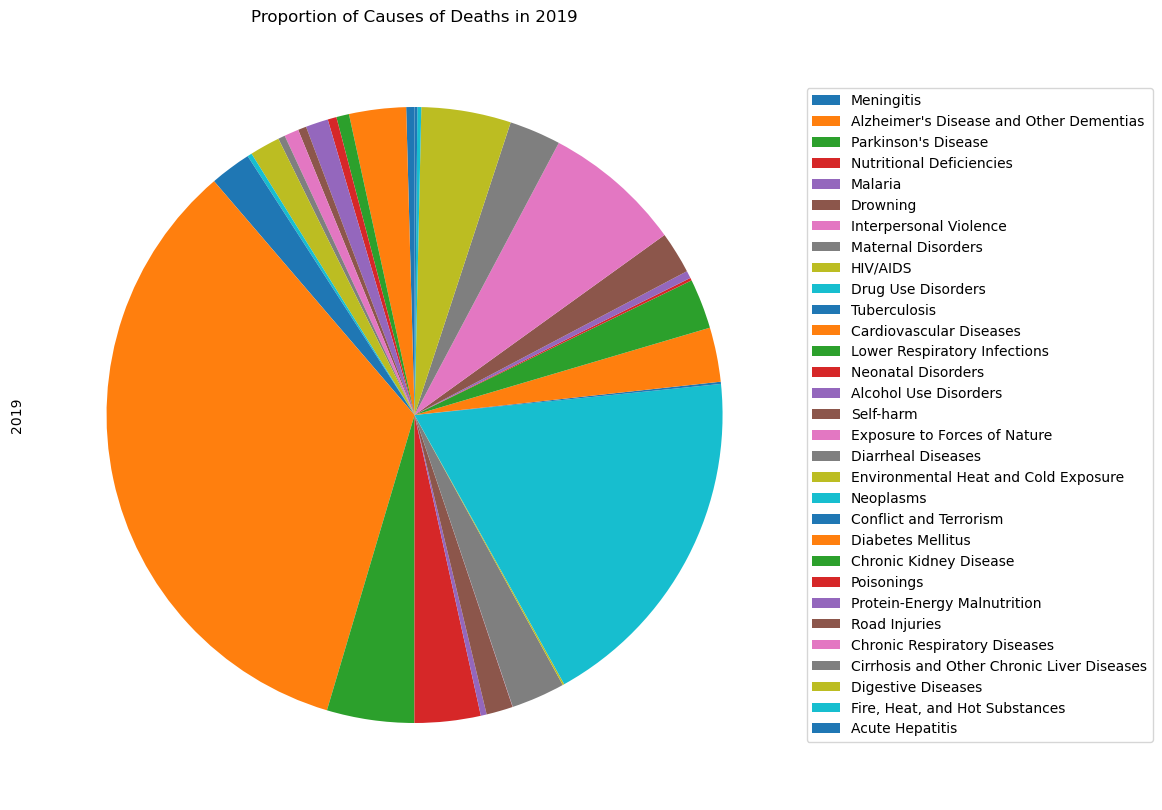

In [14]:
# 2019 data
data_2019 = global_mortality_proportion_by_year.loc[2019]

plt.figure(figsize=(10, 10))
data_2019.plot(kind='pie', startangle=90, legend=True, labels=['']*len(data_2019))
plt.title('Proportion of Causes of Deaths in 2019')
plt.legend(labels=data_2019.index, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

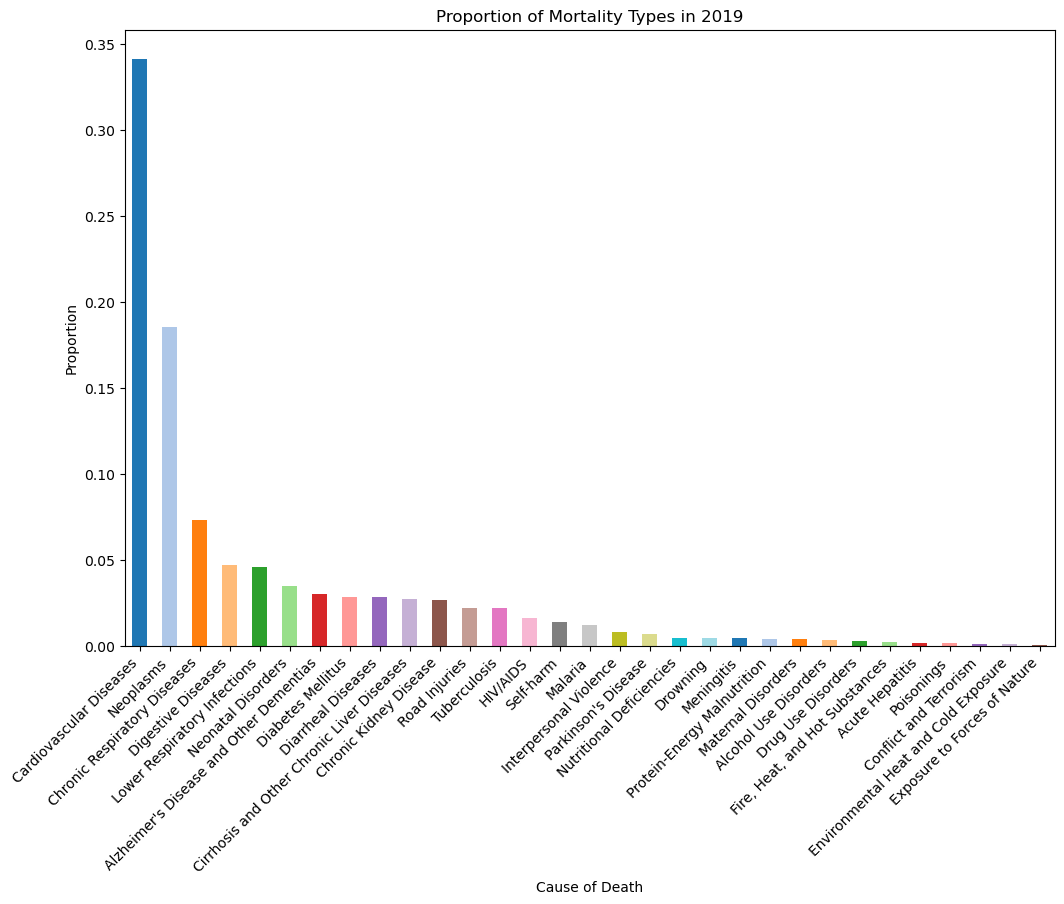

In [15]:
# Sort the data in descending order
data_2019_sorted = data_2019.sort_values(ascending=False)

plt.figure(figsize=(12, 8))
data_2019_sorted.plot(kind='bar', color=plt.cm.tab20.colors)
plt.xlabel('Cause of Death')
plt.ylabel('Proportion')
plt.title('Proportion of Mortality Types in 2019')
plt.xticks(rotation=45, ha='right')
plt.show()

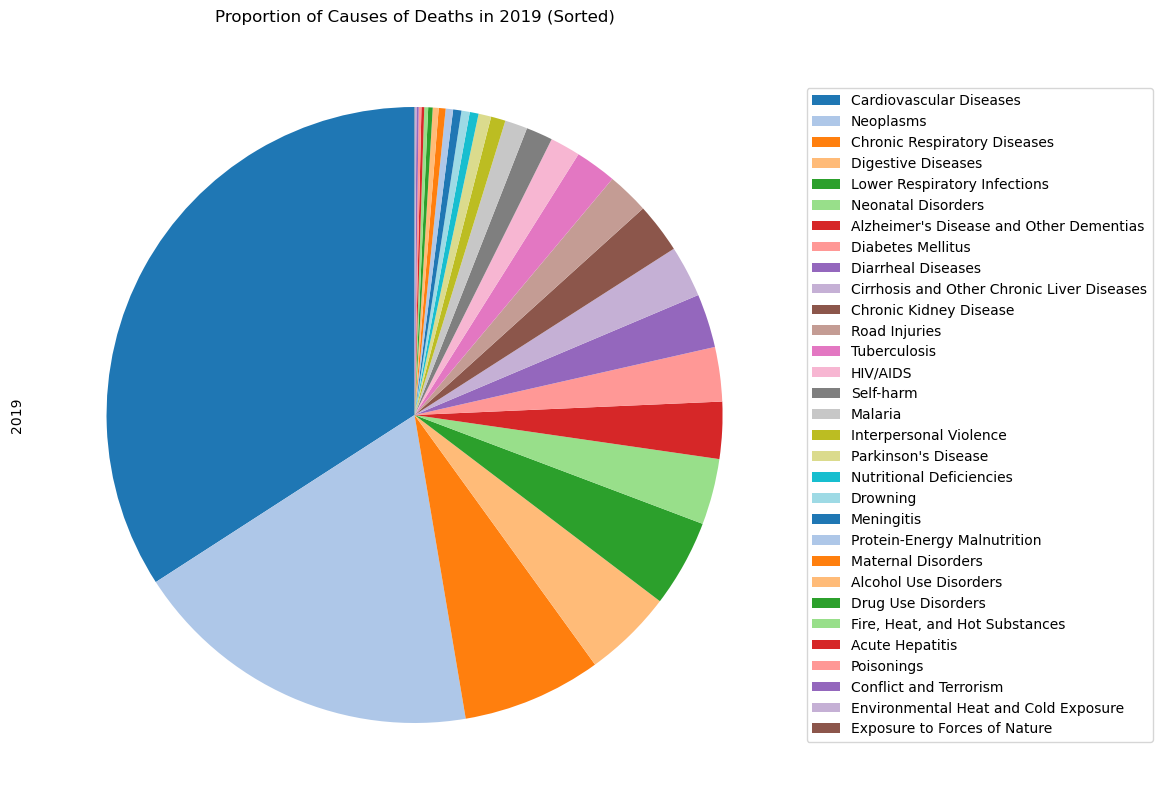

In [16]:
plt.figure(figsize=(10, 10))
data_2019_sorted.plot(kind='pie', startangle=90, legend=True, labels=['']*len(data_2019_sorted), colors=plt.cm.tab20.colors)
plt.title('Proportion of Causes of Deaths in 2019 (Sorted)')
plt.legend(labels=data_2019_sorted.index, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [17]:
data_2019_sorted.head()

Cardiovascular Diseases         0.341266
Neoplasms                       0.185315
Chronic Respiratory Diseases    0.073077
Digestive Diseases              0.047021
Lower Respiratory Infections    0.045830
Name: 2019, dtype: float64

In [18]:
df_2019_numeric.info()

<class 'pandas.core.frame.DataFrame'>
Index: 204 entries, 29 to 6119
Data columns (total 31 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Meningitis                                  204 non-null    float64
 1   Alzheimer's Disease and Other Dementias     204 non-null    float64
 2   Parkinson's Disease                         204 non-null    float64
 3   Nutritional Deficiencies                    204 non-null    float64
 4   Malaria                                     204 non-null    float64
 5   Drowning                                    204 non-null    float64
 6   Interpersonal Violence                      204 non-null    float64
 7   Maternal Disorders                          204 non-null    float64
 8   HIV/AIDS                                    204 non-null    float64
 9   Drug Use Disorders                          204 non-null    float64
 10  Tuberculosis     

In [20]:
# Calculate the change in global mortality proportions from 1990 to 2019

global_2019 = df_2019_numeric.stack().reset_index().drop(columns=['level_0'])
global_2019.columns = ['Mortality Type', 'Global Proportion']
global_2019 = global_2019.groupby('Mortality Type').mean()

df_1990 = df[df['Year'] == 1990]
df_1990_numeric = df_1990.drop(columns=['Country/Territory', 'Code', 'Year'])
global_1990 = df_1990_numeric.stack().reset_index().drop(columns=['level_0'])
global_1990.columns = ['Mortality Type', 'Global Proportion']
global_1990 = global_1990.groupby('Mortality Type').mean()

global_change = global_2019.join(global_1990, lsuffix='_2019', rsuffix='_1990', on='Mortality Type')
global_change['Change'] = global_change['Global Proportion_2019'] - global_change['Global Proportion_1990']

global_change = global_change.sort_values(by='Change', ascending=False)
global_change.head()

,Global Proportion_2019,Global Proportion_1990,Change
Mortality Type,,,
Neoplasms,0.182554,0.135670,0.046884
Cardiovascular Diseases,0.328764,0.306492,0.022272
Diabetes Mellitus,0.044149,0.027314,0.016835
HIV/AIDS,0.027433,0.011213,0.016220
Chronic Kidney Disease,0.033163,0.017970,0.015192


In [21]:
# Aggregate the proportions by cluster
df_2019_clusters = df_2019.drop(columns=['Country/Territory', 'Code', 'Year'])
cluster_agg = df_2019_clusters.groupby('Cluster').mean()
cluster_agg = cluster_agg.stack().reset_index()
cluster_agg.columns = ['Cluster', 'Mortality Type', 'Cluster Proportion']
cluster_agg.set_index(['Cluster', 'Mortality Type'], inplace=True)

cluster_agg.head()

cluster_agg = cluster_agg.join(global_2019, on='Mortality Type')
cluster_agg['Difference'] = cluster_agg['Cluster Proportion'] - cluster_agg['Global Proportion']

cluster_agg.tail()

Cluster Proportion  \
Cluster Mortality Type                                                   
5       Chronic Respiratory Diseases                          0.066884   
        Cirrhosis and Other Chronic Liver Diseases            0.033249   
        Digestive Diseases                                    0.051237   
        Fire, Heat, and Hot Substances                        0.002639   
        Acute Hepatitis                                       0.001866   

                                                    Global Proportion  \
Cluster Mortality Type                                                  
5       Chronic Respiratory Diseases                         0.045229   
        Cirrhosis and Other Chronic Liver Diseases           0.027006   
        Digestive Diseases                                   0.047418   
        Fire, Heat, and Hot Substances                       0.002417   
        Acute Hepatitis                                      0.000944   

                                                    Difference  
Cluster Mortality Type                                          
5       Chronic Respiratory Diseases                  0.021655  
        Cirrhosis and Other Chronic Liver Diseases    0.006242  
        Digestive Diseases                            0.003819  
        Fire, Heat, and Hot Substances                0.000222  
        Acute Hepatitis                               0.000921

In [22]:
import matplotlib.colors as mcolors

# Common colormap
cmap = plt.get_cmap('coolwarm')

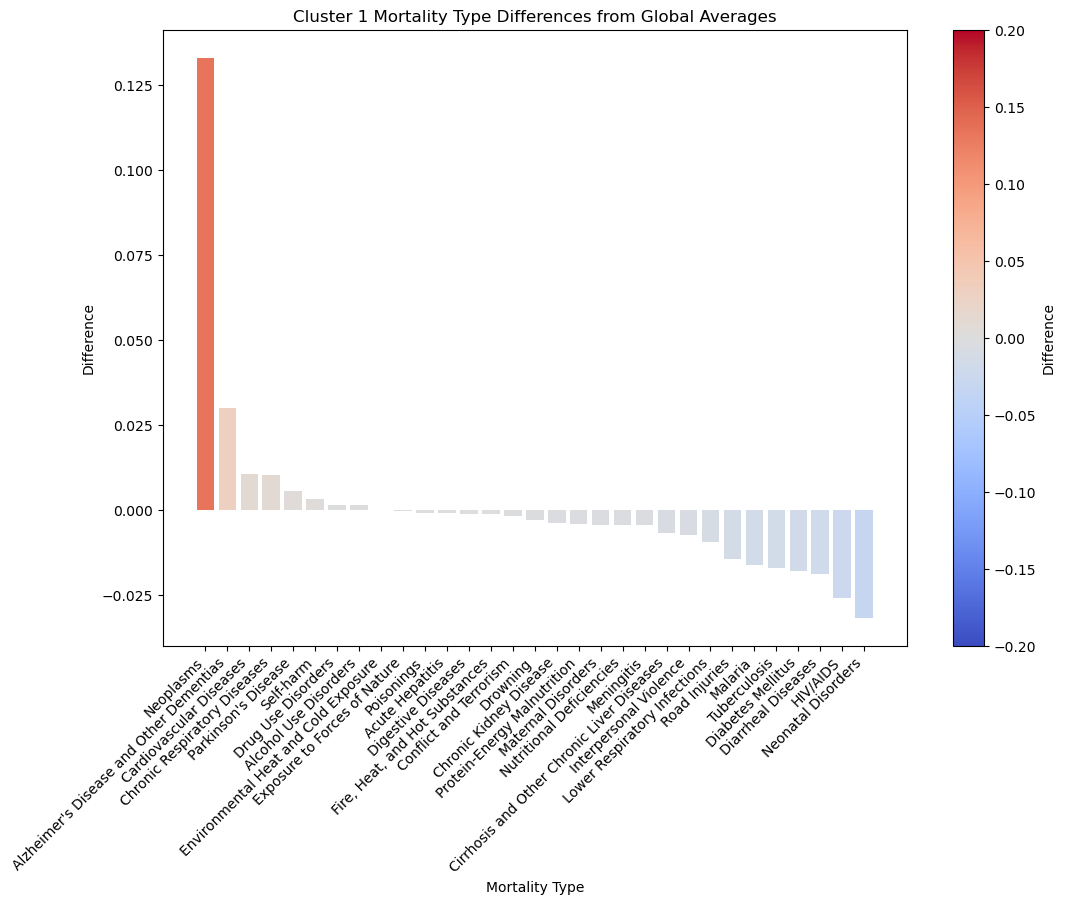

In [23]:
# Filter the data for cluster 1
cluster_1_data = cluster_agg.loc['1'].sort_values(by='Difference', ascending=False)

# Create a color map with a center at 0
cluster_vmin = -0.2
cluster_vmax = 0.2
norm = mcolors.TwoSlopeNorm(vmin=cluster_vmin, vcenter=0, vmax=cluster_vmax)
colors = cmap(norm(cluster_1_data['Difference']))

# Plot the bar chart
fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.bar(cluster_1_data.index, cluster_1_data['Difference'], color=colors)

# Add color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label='Difference')

# Set the labels and title
ax.set_xlabel('Mortality Type')
ax.set_ylabel('Difference')
ax.set_title('Cluster 1 Mortality Type Differences from Global Averages')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

plt.show()

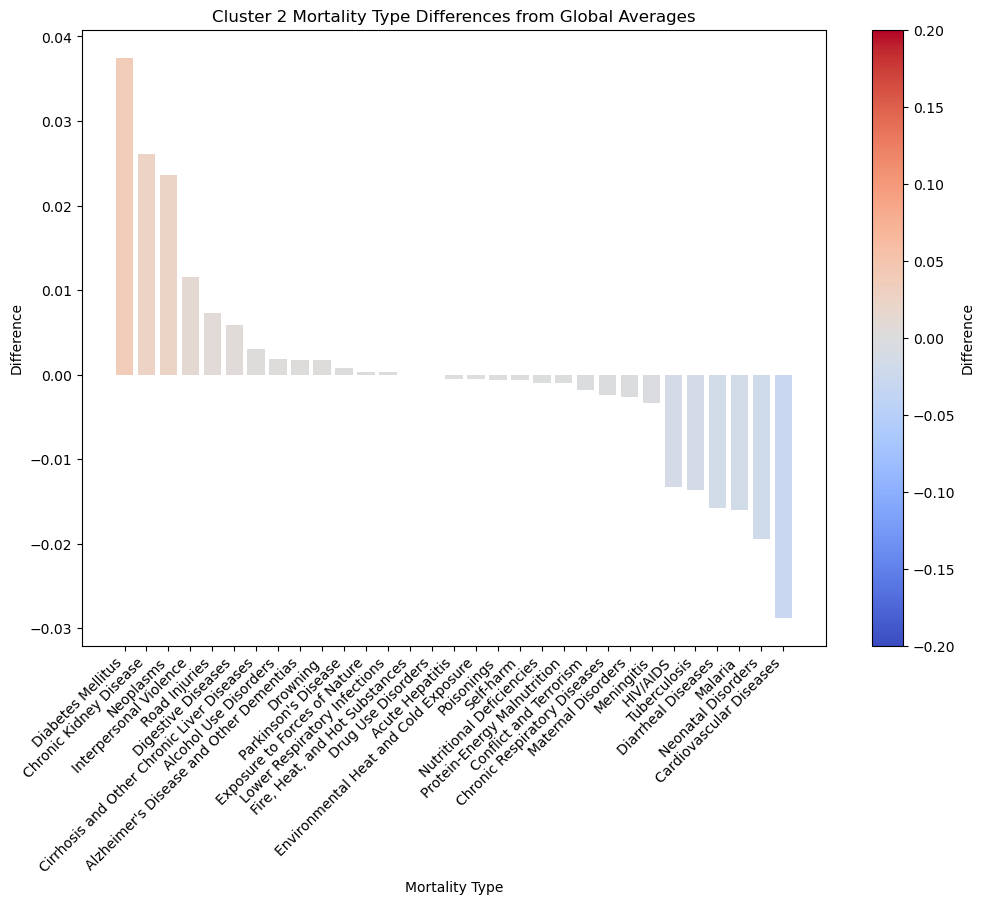

In [24]:
# Filter the data for cluster 2
cluster_2_data = cluster_agg.loc['2'].sort_values(by='Difference', ascending=False)

# Create a color map with a center at 0
norm = mcolors.TwoSlopeNorm(vmin=cluster_vmin, vcenter=0, vmax=cluster_vmax)
colors = cmap(norm(cluster_2_data['Difference']))

# Plot the bar chart
fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.bar(cluster_2_data.index, cluster_2_data['Difference'], color=colors)

# Add color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label='Difference')

# Set the labels and title
ax.set_xlabel('Mortality Type')
ax.set_ylabel('Difference')
ax.set_title('Cluster 2 Mortality Type Differences from Global Averages')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

plt.show()

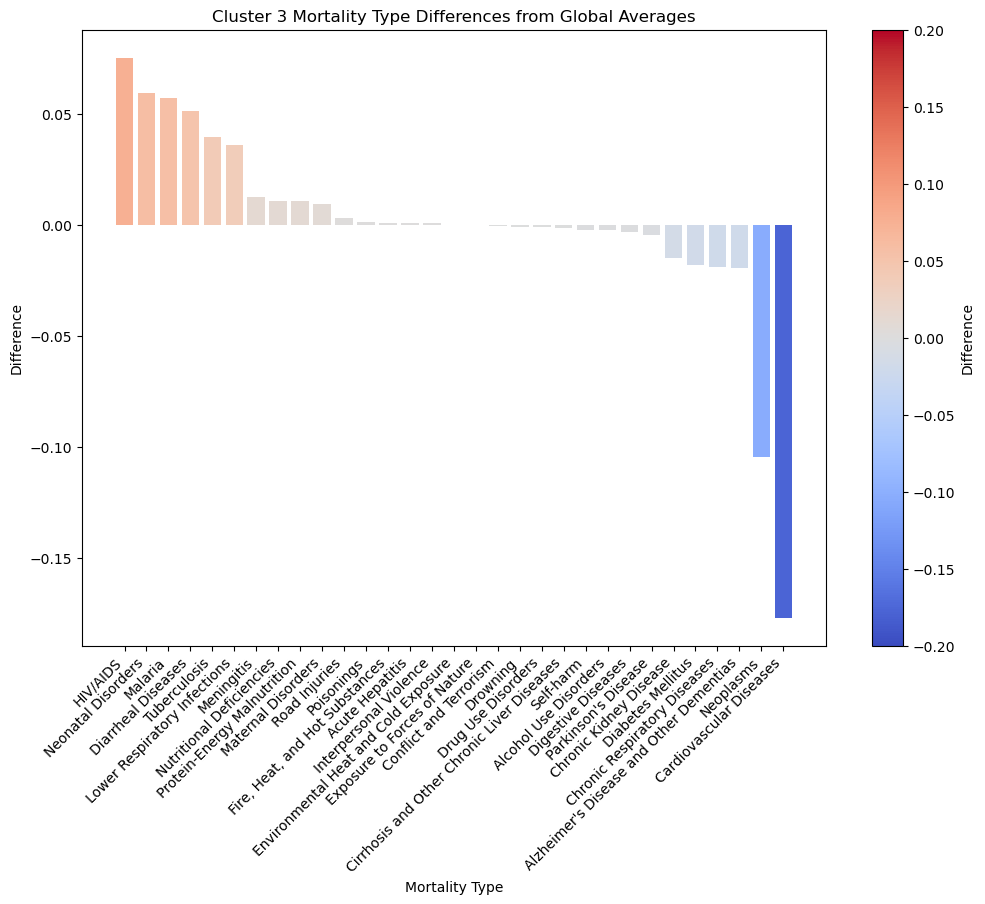

In [25]:
# Filter the data for cluster 3
cluster_3_data = cluster_agg.loc['3'].sort_values(by='Difference', ascending=False)

# Create a color map with a center at 0
norm = mcolors.TwoSlopeNorm(vmin=cluster_vmin, vcenter=0, vmax=cluster_vmax)
colors = cmap(norm(cluster_3_data['Difference']))

# Plot the bar chart
fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.bar(cluster_3_data.index, cluster_3_data['Difference'], color=colors)

# Add color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label='Difference')

# Set the labels and title
ax.set_xlabel('Mortality Type')
ax.set_ylabel('Difference')
ax.set_title('Cluster 3 Mortality Type Differences from Global Averages')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

plt.show()

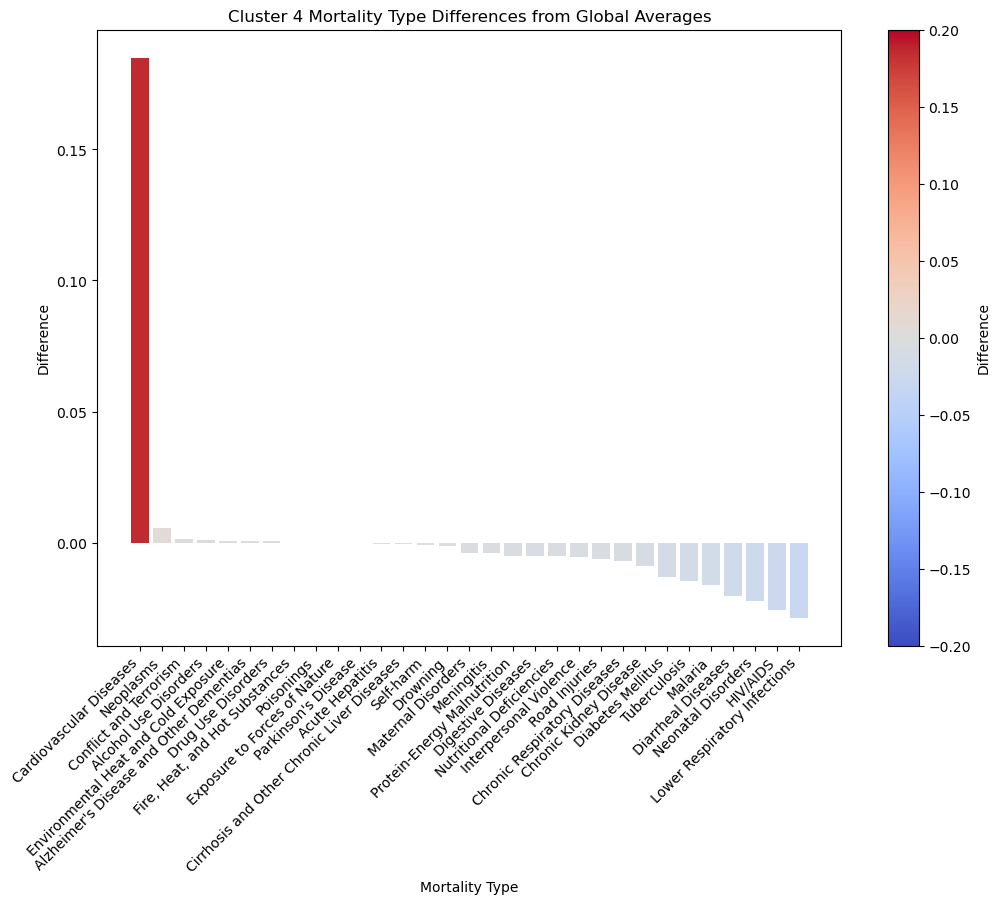

In [26]:
# Filter the data for cluster 4
cluster_4_data = cluster_agg.loc['4'].sort_values(by='Difference', ascending=False)

# Create a color map with a center at 0
norm = mcolors.TwoSlopeNorm(vmin=cluster_vmin, vcenter=0, vmax=cluster_vmax)
colors = cmap(norm(cluster_4_data['Difference']))

# Plot the bar chart
fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.bar(cluster_4_data.index, cluster_4_data['Difference'], color=colors)

# Add color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label='Difference')

# Set the labels and title
ax.set_xlabel('Mortality Type')
ax.set_ylabel('Difference')
ax.set_title('Cluster 4 Mortality Type Differences from Global Averages')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

plt.show()

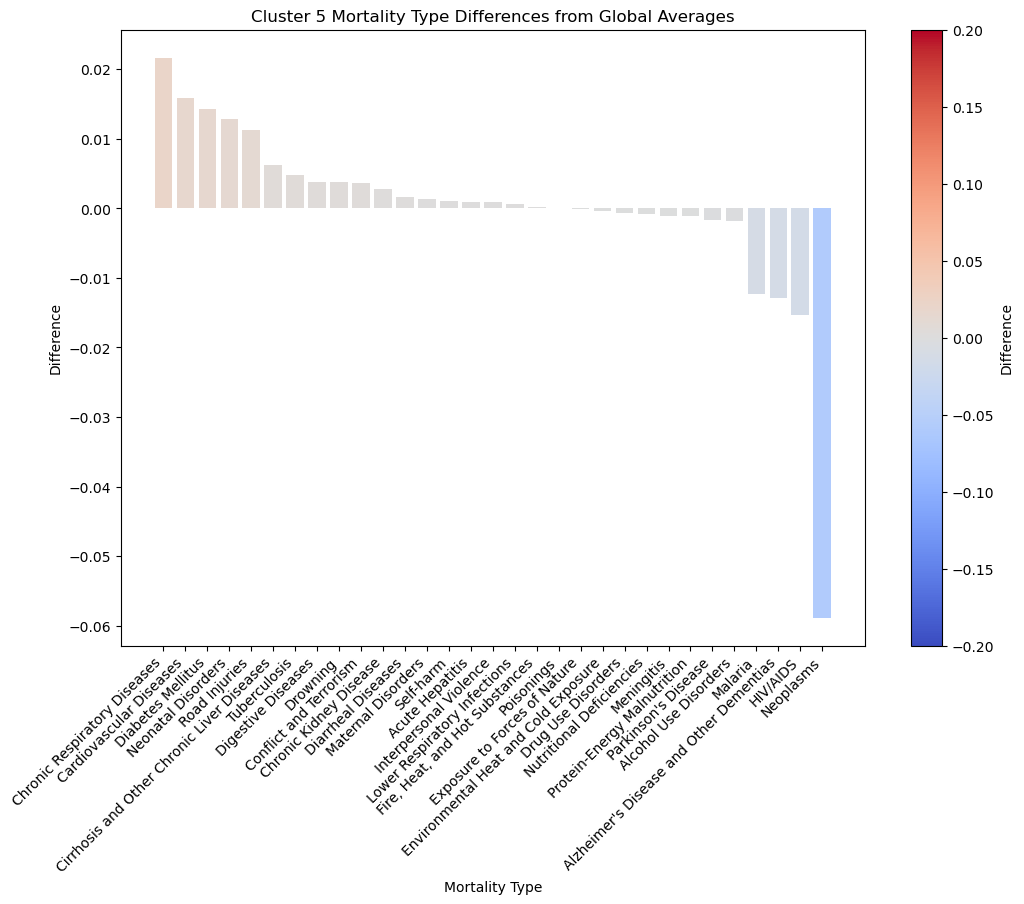

In [27]:
# Filter the data for cluster 5
cluster_5_data = cluster_agg.loc['5'].sort_values(by='Difference', ascending=False)

# Create a color map with a center at 0
norm = mcolors.TwoSlopeNorm(vmin=cluster_vmin, vcenter=0, vmax=cluster_vmax)
colors = cmap(norm(cluster_5_data['Difference']))

# Plot the bar chart
fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.bar(cluster_5_data.index, cluster_5_data['Difference'], color=colors)

# Add color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label='Difference')

# Set the labels and title
ax.set_xlabel('Mortality Type')
ax.set_ylabel('Difference')
ax.set_title('Cluster 5 Mortality Type Differences from Global Averages')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

plt.show()

In [29]:
# Calculate the change in global mortality proportions over the years

df_global_prop = df_abs.drop(columns=['Country/Territory', 'Code'])
df_global_prop = df_global_prop.groupby('Year').sum()

df_global_prop['row_sum'] = df_global_prop.sum(axis=1)
df_global_prop = df_global_prop.div(df_global_prop['row_sum'], axis=0).drop(columns=['row_sum'])

df_total_change = df_global_prop.loc[2019] - df_global_prop.loc[1990]

df_total_change = df_total_change.sort_values(ascending=False)
df_total_change = df_total_change.reset_index()
df_total_change.columns = ['Mortality Type', 'Change']
df_total_change.set_index(['Mortality Type'], inplace=True)

In [30]:
df_orig_prop = df_global_prop.loc[1990].reset_index().rename(columns={1990: 'Proportion', 'index': 'Mortality Type'})
df_global_change_flat = df_global_prop.stack().reset_index().rename(columns={0: 'Proportion', 'level_1': 'Mortality Type'})
df_global_change_prop = pd.merge(df_global_change_flat, df_orig_prop, on='Mortality Type', suffixes=('', '_1990'))
df_global_change_prop['Change'] = df_global_change_prop['Proportion'] - df_global_change_prop['Proportion_1990']
df_global_change_prop.set_index(['Year', 'Mortality Type'], inplace=True)
df_global_change_prop = df_global_change_prop[['Change']].unstack('Mortality Type')
df_global_change_prop.columns = df_global_change_prop.columns.droplevel()
df_global_change_prop.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, 1990 to 2019
Data columns (total 31 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Acute Hepatitis                             30 non-null     float64
 1   Alcohol Use Disorders                       30 non-null     float64
 2   Alzheimer's Disease and Other Dementias     30 non-null     float64
 3   Cardiovascular Diseases                     30 non-null     float64
 4   Chronic Kidney Disease                      30 non-null     float64
 5   Chronic Respiratory Diseases                30 non-null     float64
 6   Cirrhosis and Other Chronic Liver Diseases  30 non-null     float64
 7   Conflict and Terrorism                      30 non-null     float64
 8   Diabetes Mellitus                           30 non-null     float64
 9   Diarrheal Diseases                          30 non-null     float64
 10  Digestive Diseas

In [31]:
df_global_prop_2019 = df_global_prop.loc[2019]
df_global_prop_2019 = df_global_prop_2019.sort_values(ascending=False)
df_global_prop_2019.head()

Cardiovascular Diseases         0.341266
Neoplasms                       0.185315
Chronic Respiratory Diseases    0.073077
Digestive Diseases              0.047021
Lower Respiratory Infections    0.045830
Name: 2019, dtype: float64

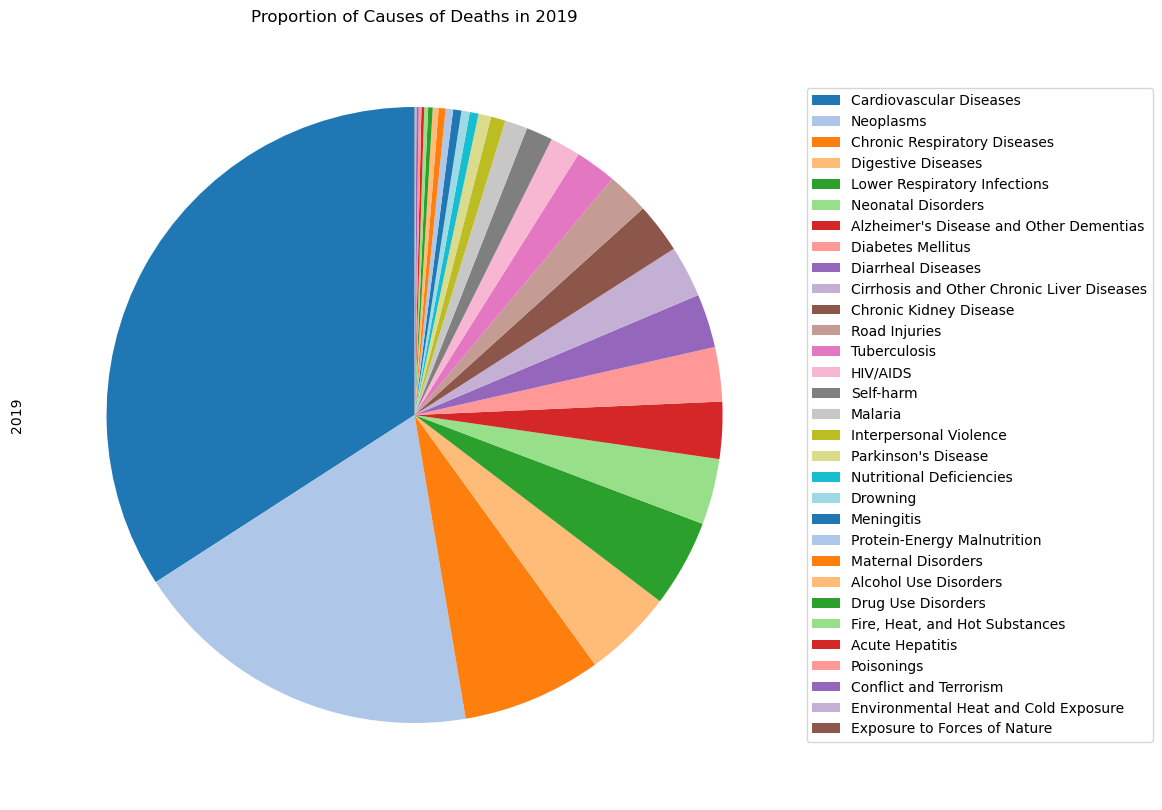

In [32]:
plt.figure(figsize=(10, 10))
df_global_prop_2019.plot(kind='pie', startangle=90, legend=True, labels=['']*len(df_global_prop_2019), colors=plt.cm.tab20.colors)
plt.title('Proportion of Causes of Deaths in 2019')
plt.legend(labels=data_2019_sorted.index, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

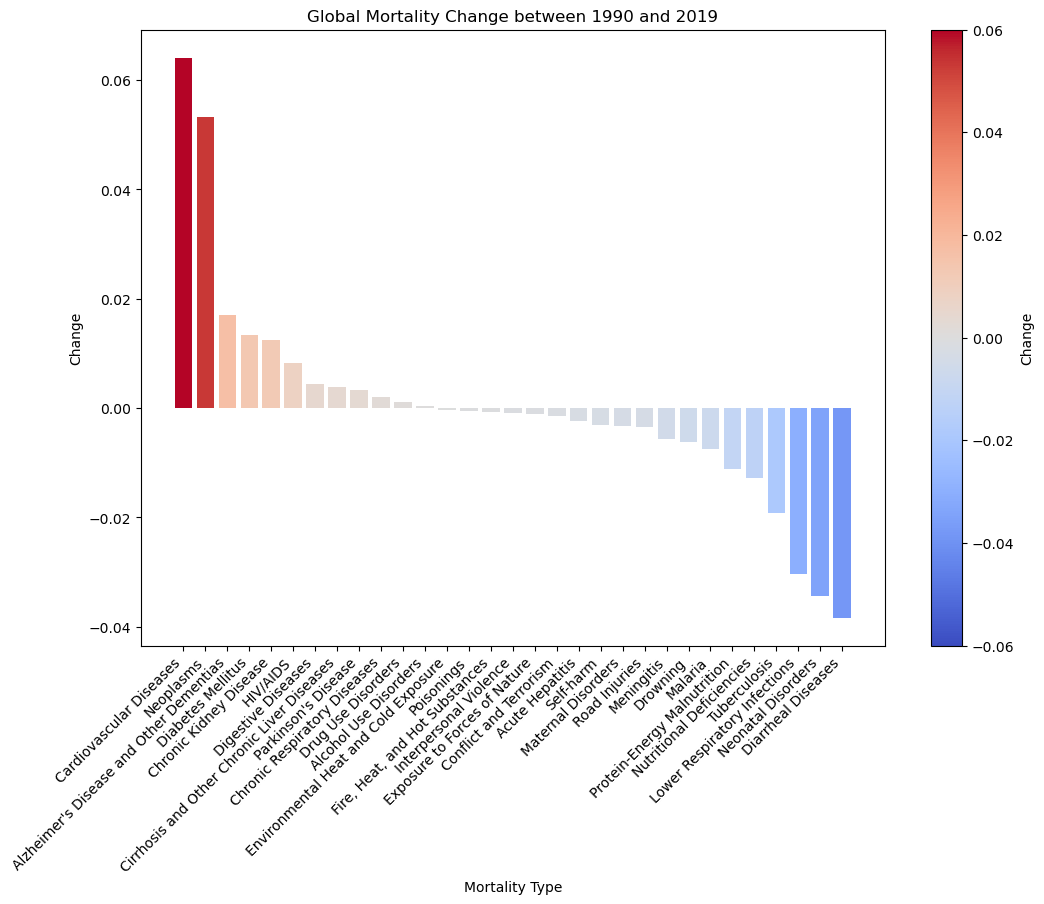

In [34]:
# Create a color map with a center at 0
vmin = -0.06
vmax = 0.06
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
colors = cmap(norm(df_total_change['Change']))

fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.bar(df_total_change.index, df_total_change['Change'], color=colors)

# Add color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label='Change')

ax.set_xlabel('Mortality Type')
ax.set_ylabel('Change')
ax.set_title('Global Mortality Change between 1990 and 2019')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

plt.show()

C:\Users\stple\AppData\Local\Temp\ipykernel_58564\4108641817.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_line = plt.cm.get_cmap('nipy_spectral', num_colors)


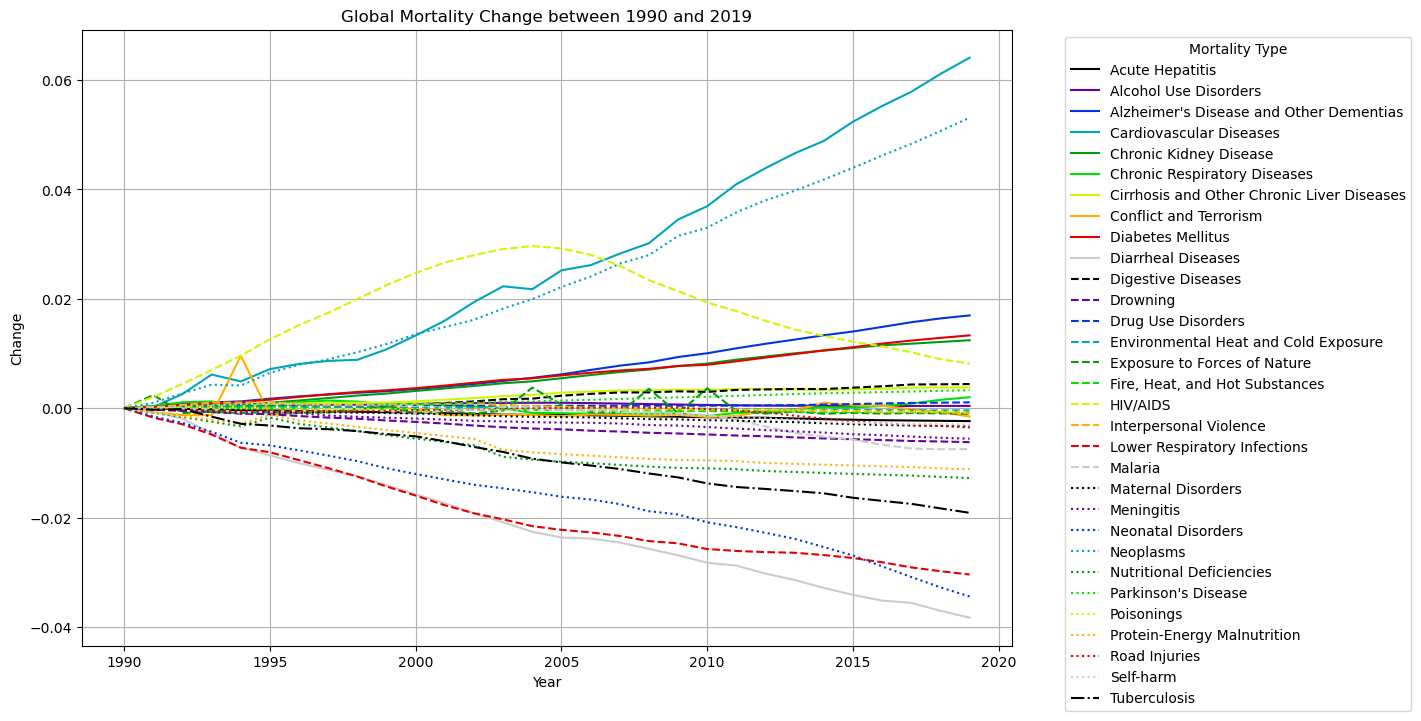

In [35]:
# Define the number of unique colors and line styles
num_colors = 10
line_styles = ['-'] * num_colors
line_styles += ['--'] * num_colors
line_styles += [':'] * num_colors
line_styles += ['-.']

# Get the categories from the column names
categories = df_global_change_prop.columns.tolist()
num_categories = len(categories)

# Create a colormap
cmap_line = plt.cm.get_cmap('nipy_spectral', num_colors)
colors = [cmap_line(i) for i in range(num_colors)]

# Map each category to a color and line style
category_styles = {}
for i, category in enumerate(categories):
    color = colors[i % num_colors]
    line_style = line_styles[i]
    category_styles[category] = {'color': color, 'line_style': line_style}

# Plot the line chart
fig, ax = plt.subplots(figsize=(12, 8))

for category in categories:
    ax.plot(
        df_global_change_prop.index,
        df_global_change_prop[category],
        label=category,
        color=category_styles[category]['color'],
        linestyle=category_styles[category]['line_style']
    )

plt.xlabel('Year')
plt.ylabel('Change')
plt.title('Global Mortality Change between 1990 and 2019')
plt.legend(title='Mortality Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.show()

In [36]:
life = pd.read_csv('life_expectancy.csv')
life = life[life['Indicator'] == 'Life expectancy at birth (years)']
life = life[life['Dim1'] == 'Both sexes']

life.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4070 entries, 2 to 23856
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   IndicatorCode               4070 non-null   object 
 1   Indicator                   4070 non-null   object 
 2   ValueType                   4070 non-null   object 
 3   ParentLocationCode          4070 non-null   object 
 4   ParentLocation              4070 non-null   object 
 5   Location type               4070 non-null   object 
 6   SpatialDimValueCode         4070 non-null   object 
 7   Location                    4070 non-null   object 
 8   Period type                 4070 non-null   object 
 9   Period                      4070 non-null   int64  
 10  IsLatestYear                4070 non-null   bool   
 11  Dim1 type                   4070 non-null   object 
 12  Dim1                        4070 non-null   object 
 13  Dim1ValueCode               4070 non-

C:\Users\stple\AppData\Local\Temp\ipykernel_58564\1967348170.py:21: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


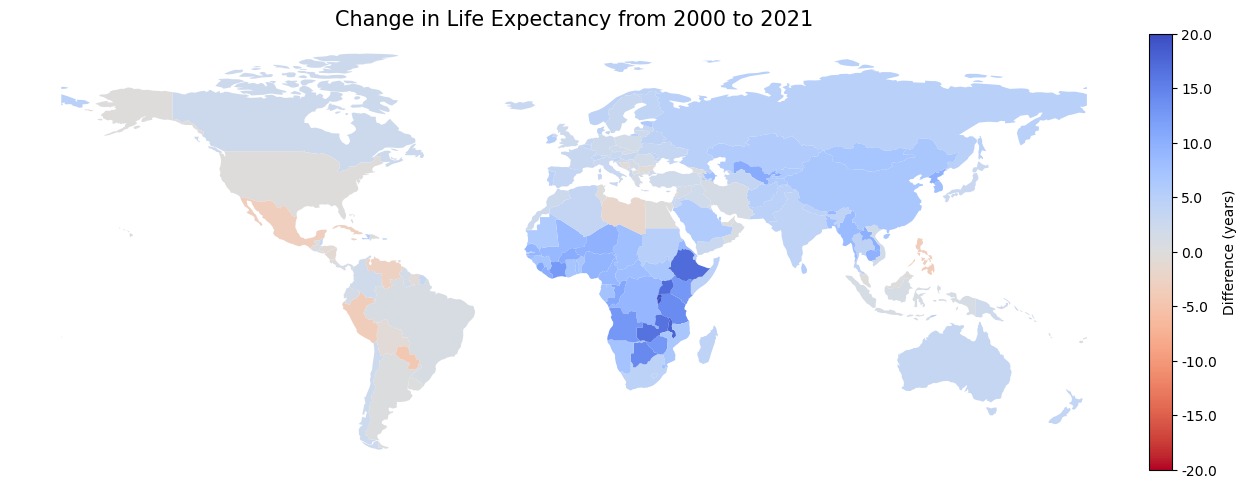

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

life_orig = life.copy()
life_orig.rename(columns={'FactValueNumeric': 'Life Expectancy', 'SpatialDimValueCode': 'Code', 'Period': 'Year'}, inplace=True)

# Filter data for the years 2000 and 2021
life_2000 = life_orig[life_orig['Year'] == 2000][['Code', 'Life Expectancy']]
life_2021 = life_orig[life_orig['Year'] == 2021][['Code', 'Life Expectancy']]

# Rename columns
life_2000.rename(columns={'Life Expectancy': 'Life Expectancy 2000'}, inplace=True)
life_2021.rename(columns={'Life Expectancy': 'Life Expectancy 2021'}, inplace=True)

# Merge the data on country code
life_diff = pd.merge(life_2000, life_2021, on='Code')

# Calculate the difference
life_diff['Life Expectancy Difference'] = life_diff['Life Expectancy 2021'] - life_diff['Life Expectancy 2000']

# Load the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge the world map with the life expectancy diff data
world_life_diff = world.merge(life_diff, how='left', left_on='iso_a3', right_on='Code')

vmin = -20
vmax = 20
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
# world_base.boundary.plot(ax=ax)
world_life_diff.plot(
    column='Life Expectancy Difference',
    cmap='coolwarm_r',
    linewidth=0.8,
    ax=ax,
    norm=norm,
    legend=False,
    )

# Set title and remove axes
ax.set_title('Change in Life Expectancy from 2000 to 2021', fontsize=15)
ax.axis('off')

# Create an axis on the right side of the plot for the colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)

# Create the colorbar
sm = plt.cm.ScalarMappable(cmap='coolwarm_r', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label('Difference (years)', rotation=90)

# Set the colorbar ticks to include negative values
num_ticks = 9
cbar_ticks = np.linspace(vmin, vmax, num_ticks)
cbar.set_ticks(cbar_ticks)
cbar.set_ticklabels([f"{t:.1f}" for t in cbar_ticks])

plt.show()

C:\Users\stple\AppData\Local\Temp\ipykernel_58564\1906891633.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


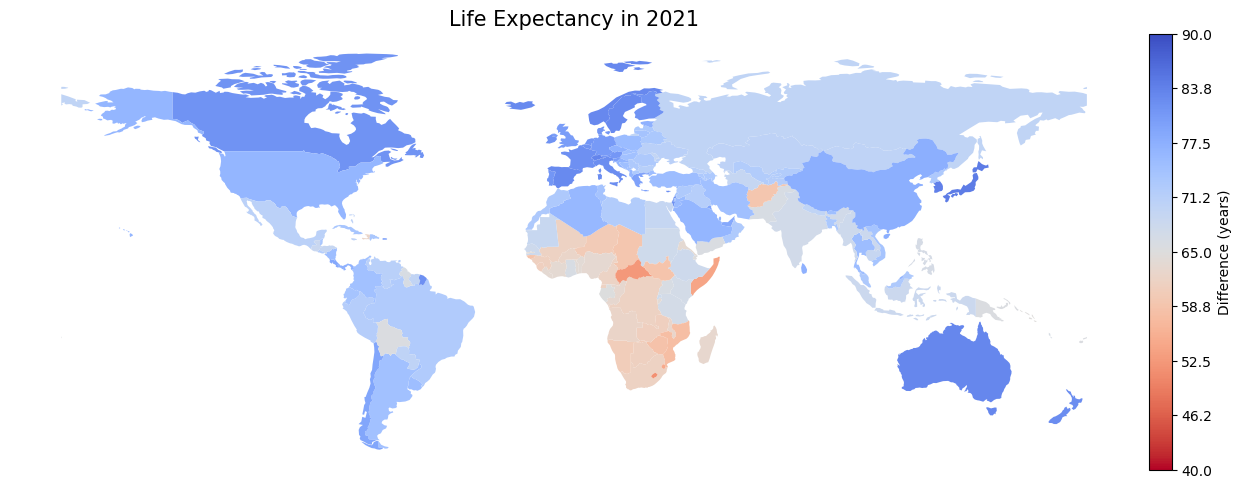

In [38]:
# Load the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge the world map with the life expectancy diff data
world_life_diff = world.merge(life_2021, how='left', left_on='iso_a3', right_on='Code')

vmin = 40
vmax = 90
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=65, vmax=vmax)

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

world_life_diff.plot(
    column='Life Expectancy 2021',
    cmap='coolwarm_r',
    linewidth=0.8,
    ax=ax,
    norm=norm,
    legend=False,
    )

# Set title and remove axes
ax.set_title('Life Expectancy in 2021', fontsize=15)
ax.axis('off')

# Create an axis on the right side of the plot for the colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)

# Create the colorbar
sm = plt.cm.ScalarMappable(cmap='coolwarm_r', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label('Difference (years)', rotation=90)

# Set the colorbar ticks to include negative values
num_ticks = 9
cbar_ticks = np.linspace(vmin, vmax, num_ticks)
cbar.set_ticks(cbar_ticks)
cbar.set_ticklabels([f"{t:.1f}" for t in cbar_ticks])

plt.show()

In [39]:
# Merging life expectancy data with the mortality data

life = pd.merge(df, life[['SpatialDimValueCode', 'Period', 'FactValueNumeric']], left_on=['Code', 'Year'], right_on=['SpatialDimValueCode', 'Period'], how='inner')
life.drop(columns=['SpatialDimValueCode', 'Period'], inplace=True)
life.rename(columns={'FactValueNumeric': 'Life Expectancy'}, inplace=True)
life = pd.merge(life, df_2019[['Code', 'Cluster']], on='Code', how='inner')
# life.to_excel('life_expectancy_merged.xlsx', index=False)

In [40]:
life_numeric = life.drop(columns=['Country/Territory', 'Code', 'Year', 'Cluster'])

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


# Split the data into features and target
X = life_numeric.drop(columns=['Life Expectancy'])
y = life_numeric['Life Expectancy']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the RF Regressor model
rf_model = RandomForestRegressor(n_estimators=20, random_state=42)

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Calculate the MSE, R2 score, and MAE
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared Score: {r2}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 0.8309590415540542
R-squared Score: 0.9889272003809407
Mean Absolute Error: 0.49781013513513506


In [662]:
import joblib

# Save the model to a file
joblib.dump(rf_model, 'random_forest_model.pkl')
print("Model saved to 'random_forest_model.pkl'")

Model saved to 'random_forest_model.pkl'


In [43]:
import joblib

# Load the model from the file
loaded_rf_model = joblib.load('random_forest_model.pkl')
print("Model loaded from 'random_forest_model.pkl'")

Model loaded from 'random_forest_model.pkl'


In [44]:
# Convert y_pred and y_test to DataFrames
y_pred_df = pd.DataFrame(y_pred, index=X_test.index, columns=['Predicted Life Expectancy'])

# Concatenate X_test, y_test_df, and y_pred_df
result_df = pd.merge(X_test, y_pred_df, left_index=True, right_index=True)
result_df['Actual Life Expectancy'] = y_test

# Export to excel
result_df.to_excel('predicted_life_expectancy.xlsx', index=True)

In [45]:
life_2019 = life[life['Year'] == 2019].copy()
life_2019['Adjusted Column'] = ''
mortality_cols = [col for col in life_2019.columns if col not in ['Country/Territory', 'Code', 'Year', 'Life Expectancy', 'Cluster', 'Adjusted Column']]

ADJUSTMENT_RATE = 0.25
life_2019_adjusted_data = []
for index, row in life_2019.iterrows():
    for col in mortality_cols:
        new_row = row.copy()
        new_row['Adjusted Column'] = col
        adjustment = new_row[col] * (1 - ADJUSTMENT_RATE)
        new_row[col] = adjustment
        A = (1 - new_row[col]) / (1 - row[col])
        for c in mortality_cols:
            if c != col:
                new_row[c] = new_row[c] * A
        life_2019_adjusted_data.append(new_row)

life_2019_adjusted = pd.DataFrame(life_2019_adjusted_data, columns=life_2019.columns)

# life_2019_adjusted['sum'] = life_2019_adjusted[mortality_cols].sum(axis=1)

# life_2019_adjusted.to_excel('life_expectancy_adjusted.xlsx', index=False)

life_2019_adjusted.head()

,Country/Territory,Code,Year,Meningitis,Alzheimer's Disease and Other Dementias,Parkinson's Disease,Nutritional Deficiencies,Malaria,Drowning,Interpersonal Violence,...,Protein-Energy Malnutrition,Road Injuries,Chronic Respiratory Diseases,Cirrhosis and Other Chronic Liver Diseases,Digestive Diseases,"Fire, Heat, and Hot Substances",Acute Hepatitis,Life Expectancy,Cluster,Adjusted Column
19,Afghanistan,AFG,2019,0.005386,0.008170,0.002578,0.005726,0.002440,0.007765,0.023084,...,0.005570,0.037993,0.032599,0.017478,0.031894,0.002232,0.008930,61.22,5,Meningitis
19,Afghanistan,AFG,2019,0.007196,0.006117,0.002578,0.005728,0.002440,0.007767,0.023090,...,0.005571,0.038003,0.032607,0.017482,0.031902,0.002233,0.008932,61.22,5,Alzheimer's Disease and Other Dementias
19,Afghanistan,AFG,2019,0.007186,0.008161,0.001930,0.005720,0.002437,0.007756,0.023057,...,0.005563,0.037949,0.032561,0.017457,0.031857,0.002230,0.008920,61.22,5,Parkinson's Disease
19,Afghanistan,AFG,2019,0.007192,0.008167,0.002577,0.004287,0.002439,0.007762,0.023076,...,0.005568,0.037979,0.032587,0.017471,0.031883,0.002232,0.008927,61.22,5,Nutritional Deficiencies
19,Afghanistan,AFG,2019,0.007186,0.008161,0.002575,0.005719,0.001826,0.007756,0.023057,...,0.005563,0.037948,0.032560,0.017457,0.031856,0.002230,0.008919,61.22,5,Malaria


In [46]:
# Configure data for maximum improvement map

life_2019_numeric = life_2019.drop(columns=['Country/Territory', 'Code', 'Year', 'Cluster', 'Life Expectancy', 'Adjusted Column'])
life_2019_adjusted_numeric = life_2019_adjusted.drop(columns=['Country/Territory', 'Code', 'Year', 'Cluster', 'Life Expectancy', 'Adjusted Column'])

life_2019_numeric_pred = life_2019.copy()
life_2019_adjusted_numeric_pred = life_2019_adjusted.copy()

orig_pred = loaded_rf_model.predict(life_2019_numeric)
pred = loaded_rf_model.predict(life_2019_adjusted_numeric)

life_2019_numeric_pred['Predicted Life Expectancy'] = orig_pred
life_2019_adjusted_numeric_pred['Adjusted - Predicted Life Expectancy'] = pred

result = pd.merge(life_2019_adjusted_numeric_pred, life_2019_numeric_pred[['Code', 'Predicted Life Expectancy']], on='Code', how='inner')
result['Difference'] = result['Adjusted - Predicted Life Expectancy'] - result['Predicted Life Expectancy']

diff = result.groupby("Code")["Difference"].max().reset_index()
result = pd.merge(result, diff, on="Code", how="inner", suffixes=('', ' Max'))

result = result[result['Difference'] == result['Difference Max']].drop(columns=['Difference Max'])

result['Adjusted Column'] = np.where(result['Difference'] == 0, 'No Improvement Found', result['Adjusted Column'])
result = result.drop_duplicates(subset=['Code'])

result.to_excel('life_expectancy_adjusted_result.xlsx', index=False)

C:\Users\stple\AppData\Local\Temp\ipykernel_58564\1253301361.py:8: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
C:\Users\stple\AppData\Local\Temp\ipykernel_58564\1253301361.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_final = plt.cm.get_cmap('tab20', num_colors)


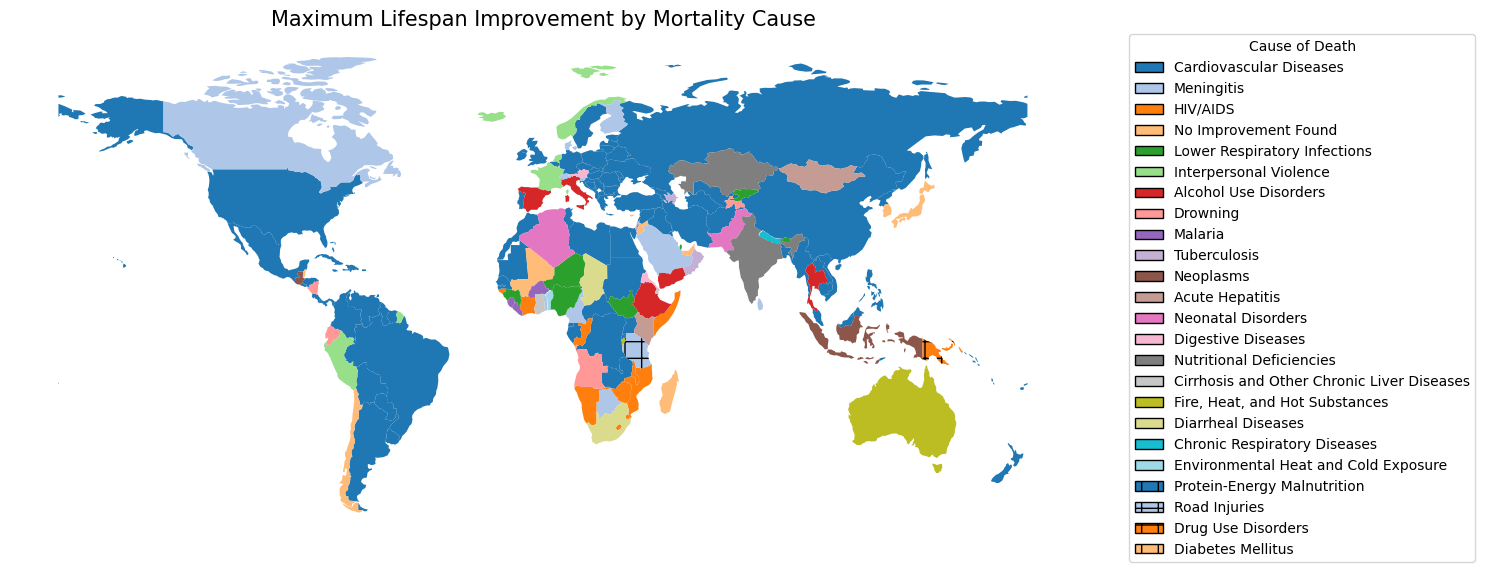

In [47]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches

# Load a world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge the world map with the result df
world_result = world.merge(result, how="left", left_on="iso_a3", right_on="Code")

# Get unique categories sorted by frequency
adjusted_column_order = world_result['Adjusted Column'].value_counts().index
num_categories = len(adjusted_column_order)

# Define the colormap
num_colors = 20
cmap_final = plt.cm.get_cmap('tab20', num_colors)

# Define a list of hatch patterns
hatches = [''] * num_colors
hatches += ['+'] * (num_categories - num_colors)
# Repeat the hatch list if there are more categories than hatch patterns
hatches = (hatches * (num_categories // len(hatches) + 1))[:num_categories]

# Create a color and pattern mapping
category_styles = {category: {'color': cmap_final(i % num_colors), 'hatch': hatches[i]} 
                   for i, category in enumerate(adjusted_column_order)}

# Plot the map
fig, ax = plt.subplots(figsize=(15, 10))

# Plot each category with its corresponding color and hatch
for category in adjusted_column_order:
    subset = world_result[world_result['Adjusted Column'] == category]
    style = category_styles[category]
    subset.plot(ax=ax, color=style['color'], 
               edgecolor='black', hatch=style['hatch'] if style['hatch'] else None, 
               label=category, linewidth=0.)

# Create custom legend handles
legend_patches = []
for category in adjusted_column_order:
    style = category_styles[category]
    patch = mpatches.Patch(facecolor=style['color'], edgecolor='black', 
                           hatch=style['hatch'] if style['hatch'] else None, 
                           label=category)
    legend_patches.append(patch)

# Add the legend outside the plot
ax.legend(handles=legend_patches, title='Cause of Death', 
          bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Remove axes
ax.axis('off')

# Set title
plt.title('Maximum Lifespan Improvement by Mortality Cause', fontsize=15)

# Adjust layout to make room for the legend
plt.tight_layout()

plt.show()

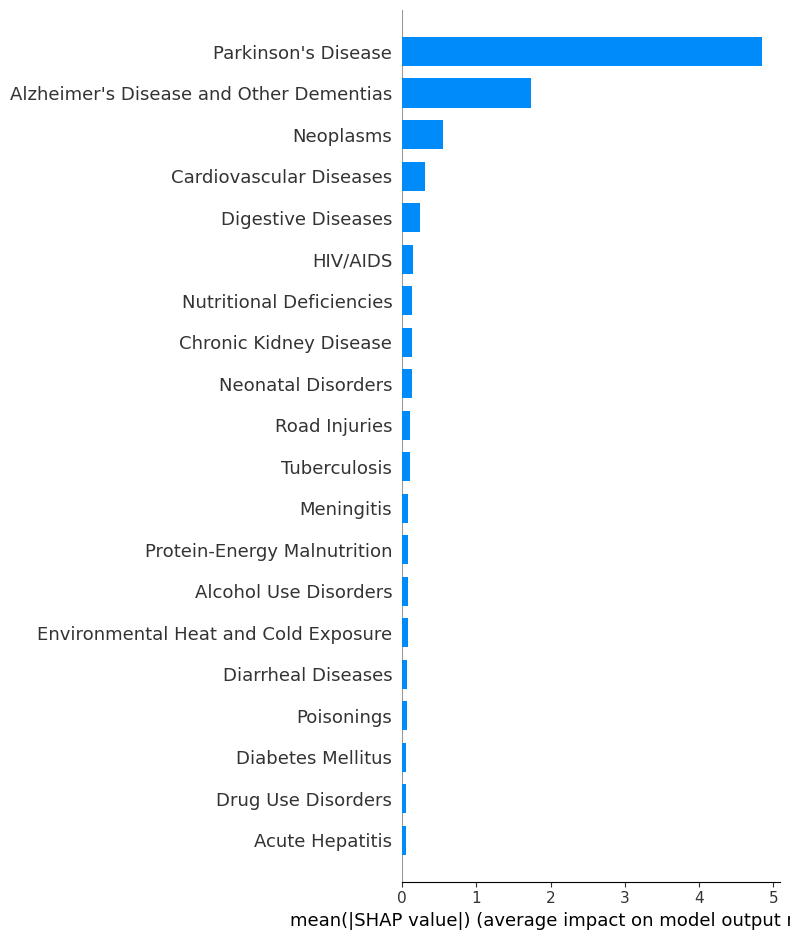

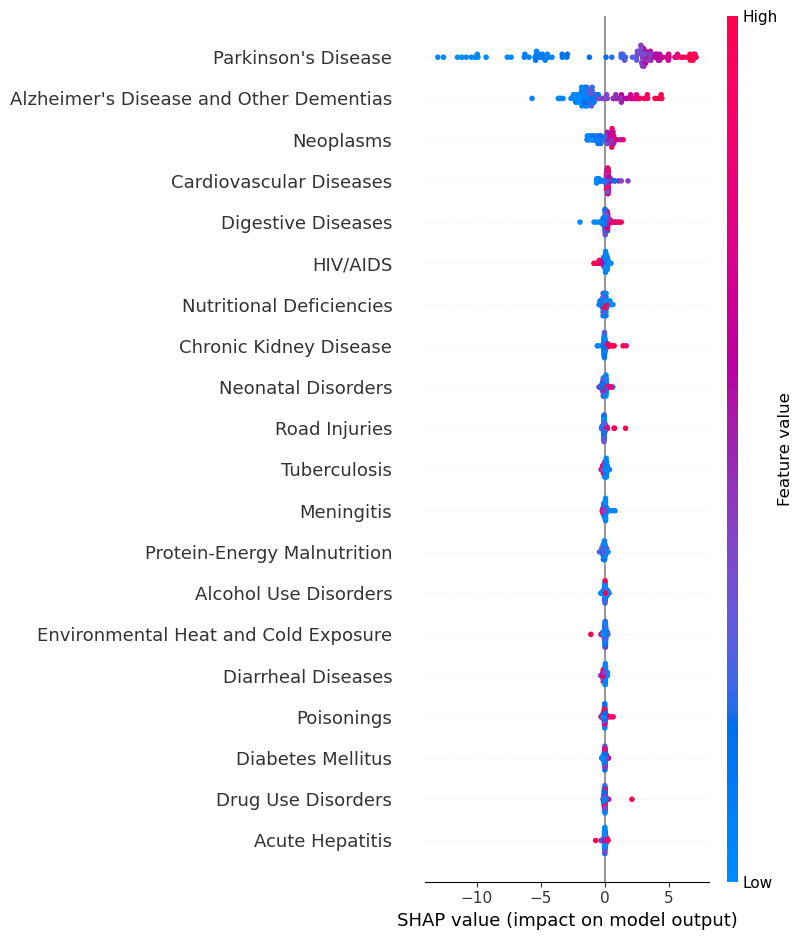

In [ ]:
import shap

explainer = shap.TreeExplainer(loaded_rf_model)

# Compute SHAP values
X_sample = X_train.sample(n=100, random_state=2) 
shap_values = explainer.shap_values(X_sample)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_sample, plot_type="bar")

# Detailed SHAP summary plot
shap.summary_plot(shap_values, X_sample)